### Домашнее задание <a class="anchor" id="hw"></a><center>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
# сгенерируем данные
classification_data, classification_labels = make_classification(n_samples=1000, n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=5)

In [4]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [5]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [6]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [7]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [8]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [9]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [10]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [11]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [12]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [13]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [14]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [15]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [16]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)
print_tree(my_tree)

Индекс 0 <= -0.001967524769128759
--> True:
  Индекс 1 <= -1.3993975578815423
  --> True:
    Индекс 1 <= -1.6646404646216442
    --> True:
      Индекс 0 <= -0.8728986138474495
      --> True:
        Прогноз: 0
      --> False:
        Прогноз: 0
    --> False:
      Индекс 0 <= -0.6882680999463433
      --> True:
        Прогноз: 0
      --> False:
        Индекс 0 <= -0.40118216125291906
        --> True:
          Индекс 1 <= -1.5684737117409848
          --> True:
            Индекс 0 <= -0.5543283463967666
            --> True:
              Прогноз: 1
            --> False:
              Прогноз: 1
          --> False:
            Прогноз: 0
        --> False:
          Индекс 1 <= -1.5264301097909836
          --> True:
            Прогноз: 1
          --> False:
            Индекс 1 <= -1.4255078037225668
            --> True:
              Прогноз: 1
            --> False:
              Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Индекс 1 <= -1.4518330557811816
  -->

In [17]:
def check_accuracy(my_tree):
    train_answers = predict(train_data, my_tree)

    train_accuracy = accuracy_metric(train_labels, train_answers)
    print(train_accuracy)

    answers = predict(test_data, my_tree)

    test_accuracy = accuracy_metric(test_labels, answers)
    print(test_accuracy)

In [18]:
check_accuracy(my_tree)

98.14285714285714
95.0


**1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)**

*Количество листьев*

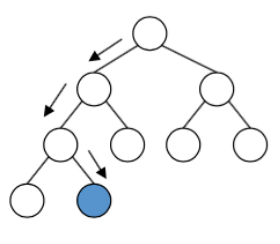

In [21]:
def build_tree(data, labels):
    global max_leaves, depth, num_leaves
    
    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    # или когда количество листьев стало больше максимального
    print(num_leaves, depth)
    if gain == 0 or num_leaves >= max_leaves - 1 or depth >= max_leaves - 1:
        num_leaves += 1
        return Leaf(data, labels)

    depth += 1
    
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [22]:
# Построим дерево по обучающей выборке
num_leaves = 0
max_leaves = 3
depth = 0

my_tree = build_tree(train_data, train_labels)
print_tree(my_tree)

0 0
0 1
0 2
1 2
2 2
Индекс 0 <= -0.001967524769128759
--> True:
  Индекс 1 <= -1.3993975578815423
  --> True:
    Прогноз: 0
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


*Глубина дерева*

In [23]:
# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels, max_depth):
    
    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    # или когда достигли максимальной глубины дерева
    if gain == 0 or max_depth == 0:
        return Leaf(data, labels)
    
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, max_depth - 1)
    false_branch = build_tree(false_data, false_labels, max_depth - 1)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [25]:
# Построим дерево по обучающей выборке

my_tree = build_tree(train_data, train_labels, max_depth=5)
print_tree(my_tree)

Индекс 0 <= -0.001967524769128759
--> True:
  Индекс 1 <= -1.3993975578815423
  --> True:
    Индекс 1 <= -1.6646404646216442
    --> True:
      Индекс 0 <= -0.8728986138474495
      --> True:
        Прогноз: 0
      --> False:
        Прогноз: 0
    --> False:
      Индекс 0 <= -0.6882680999463433
      --> True:
        Прогноз: 0
      --> False:
        Индекс 0 <= -0.40118216125291906
        --> True:
          Прогноз: 0
        --> False:
          Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Индекс 1 <= -1.4518330557811816
  --> True:
    Прогноз: 0
  --> False:
    Индекс 0 <= 0.08948763365897339
    --> True:
      Индекс 0 <= 0.04459943514365716
      --> True:
        Прогноз: 1
      --> False:
        Прогноз: 1
    --> False:
      Индекс 0 <= 1.2003150546431454
      --> True:
        Индекс 0 <= 1.1480251121818283
        --> True:
          Прогноз: 1
        --> False:
          Прогноз: 1
      --> False:
        Прогноз: 1


In [28]:
check_accuracy(my_tree)

94.42857142857143
93.66666666666667


**Класс дерева**

In [26]:
# ИЗМЕНЕНИЯ: дерево организуем тоже классом
# Класс дерева

class Tree:
    
    # ИЗМЕНЕНИЯ: здесь указаны параметры для останова
    def __init__(self,
                 max_tree_depth_stop=np.inf,
                 max_leaf_num_stop=np.inf,
                 min_leaf_object_stop=1):
        self.max_depth = max_tree_depth_stop
        self.nodes = []
        self.leaves = []
        self.depth = 0
        self.max_leaves = max_leaf_num_stop
        self.min_objects = min_leaf_object_stop
        self.tree = None
        
    # Расчет критерия Джини
    def gini(self,
             labels):
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2

        return impurity
    
    # Расчет прироста
    def gain(self,
             left_labels,
             right_labels,
             root_gini):

        # доля выборки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return root_gini - p * self.gini(left_labels) - (1 - p) * self.gini(right_labels)
    
    # Разбиение датасета в узле
    def split(self,
              data,
              labels,
              column_index,
              t):

        left = np.where(data[:, column_index] <= t)
        right = np.where(data[:, column_index] > t)

        true_data = data[left]
        false_data = data[right]

        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
    # Нахождение наилучшего разбиения
    def find_best_split(self,
                        data,
                        labels):

        #  обозначим минимальное количество объектов в узле
        min_samples_leaf = 5

        root_gini = self.gini(labels)

        best_gain = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique(data[:, index])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                    continue

                current_gain = self.gain(true_labels, false_labels, root_gini)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_gain > best_gain:
                    best_gain, best_t, best_index = current_gain, t, index

        return best_gain, best_t, best_index
    
    # Построение дерева с помощью рекурсивной функции
    def build_tree(self,
                   data,
                   labels):

        gain, t, index = self.find_best_split(data, labels)
        
        # ИЗМЕНЕНИЯ: здесь добавила базовые случаи для остановки построения дерева
 
        #  Базовый случай 2 - прекращаем рекурсию, когда достигли максимальной глубины дерева
        if self.depth > self.max_depth:
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)
        
        #  Базовый случай 3 - прекращаем рекурсию, когда достигли максимального количества листьев
        if len(self.leaves) >= self.max_leaves - 1 or self.depth >= self.max_leaves - 1:
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)
        
        #  Базовый случай 4 - прекращаем рекурсию, когда достигли минимального количества объектов в листе
        if len(data) <= self.min_objects:
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)
        
         #  Базовый случай 1 - прекращаем рекурсию, когда нет прироста в качества
        if gain == 0:
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)

        self.depth += 1
        
        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels)
        false_branch = self.build_tree(false_data, false_labels)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        self.nodes.append(Node(index, t, true_branch, false_branch))
        return Node(index, t, true_branch, false_branch)
    
    def classify_object(self,
                        obj,
                        node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)
    
    def fit(self, data, labels):
        self.tree = self.build_tree(data, labels)
        return self
    
    def predict(self, data):
    
        classes = []
        for obj in data:
            prediction = self.classify_object(obj, self.tree)
            classes.append(prediction)
        return classes

In [27]:
# Построим несколько деревьев с разными критериями останова по обучающей выборке 
tree_1 = Tree() # без критерия
tree_1.fit(train_data, train_labels)

tree_2 = Tree(max_tree_depth_stop=5) # ограничим глубину дерева
tree_2.fit(train_data, train_labels)

tree_3 = Tree(max_leaf_num_stop=20) # ограничим количество листьев
tree_3.fit(train_data, train_labels)

tree_4 = Tree(min_leaf_object_stop=50) # ограничим количество объектов в листе
tree_4.fit(train_data, train_labels)

In [28]:
accuracy_metric(train_labels, tree_2.predict(train_data))

91.85714285714286

In [29]:
accuracy_metric(test_labels, tree_2.predict(test_data))

85.66666666666667

In [30]:
print('Максимальная глубина: 5\n')
print(f'Глубина:{tree_2.depth},листьев:{len(tree_2.leaves)}\n')
print_tree(tree_2.tree)

Максимальная глубина: 5

Глубина:6,листьев:7

Индекс 0 <= -0.001967524769128759
--> True:
  Индекс 1 <= -1.3993975578815423
  --> True:
    Индекс 1 <= -1.6646404646216442
    --> True:
      Индекс 0 <= -0.8728986138474495
      --> True:
        Прогноз: 0
      --> False:
        Прогноз: 0
    --> False:
      Индекс 0 <= -0.6882680999463433
      --> True:
        Прогноз: 0
      --> False:
        Индекс 0 <= -0.40118216125291906
        --> True:
          Прогноз: 0
        --> False:
          Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


**2. *Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.**

In [31]:
# сгенерируем данные
data, targets = make_regression(n_features=2, n_informative=2, random_state=5)

In [32]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data_regr, test_data_regr, train_target_regr, test_target_regr = train_test_split(data, 
                                                                                        targets, 
                                                                                        test_size=0.3,
                                                                                        random_state=1)

In [33]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        self.prediction = self.predict()
        
    def predict(self):
        return self.targets.mean()

In [34]:
def mse(targets):
    return np.mean((targets - targets.mean())**2)

In [35]:
# Нахождение наилучшего разбиения

def find_best_split(data, targets):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 5

    root_mse = mse(targets)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_targets, false_targets = split(data, targets, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_targets, false_targets, root_mse)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [36]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, target):

    gain, t, index = find_best_split(data, target)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, target)

    true_data, false_data, true_target, false_target = split(data, target, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_target)
    false_branch = build_tree(false_data, false_target)

    node = Node(index, t, true_branch, false_branch)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return node

In [37]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data_regr, train_target_regr)
print_tree(my_tree)

Индекс 0 <= -1.167278449710173
--> True:
  Прогноз: -121.39064849773837
--> False:
  Индекс 0 <= -0.8126247611063044
  --> True:
    Прогноз: -58.83807643952095
  --> False:
    Индекс 0 <= -0.5017555471945
    --> True:
      Прогноз: -50.68338930141631
    --> False:
      Индекс 0 <= -0.28143012121166766
      --> True:
        Прогноз: -19.53457742091028
      --> False:
        Индекс 0 <= 0.10134479014204936
        --> True:
          Индекс 0 <= -0.10593044205742323
          --> True:
            Прогноз: -19.179384142931184
          --> False:
            Прогноз: 11.007437547567205
        --> False:
          Индекс 0 <= 0.30364846530823975
          --> True:
            Прогноз: 17.82546436535075
          --> False:
            Индекс 0 <= 0.6178447508392777
            --> True:
              Индекс 0 <= 0.44295626086393586
              --> True:
                Прогноз: 32.35717501918585
              --> False:
                Прогноз: 44.73161236384692
            

In [38]:
from sklearn.metrics import r2_score

train_answers = predict(train_data_regr, my_tree)
train_r2 = r2_score(train_target_regr, train_answers)
print(train_r2)

answers = predict(test_data_regr, my_tree)
test_r2 = r2_score(test_target_regr, answers)
print(test_r2)

0.8994102006971118
0.8047526472601623


In [39]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()
tree.fit(train_data_regr, train_target_regr)

train_answers = tree.predict(train_data_regr)
train_r2 = r2_score(train_target_regr, train_answers)
print(train_r2)

answers = tree.predict(test_data_regr)
test_r2 = r2_score(test_target_regr, answers)
print(test_r2)

1.0
0.8424305194559368


**Реализация через классы**

In [40]:
class Leaf_clsf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        
    

class Leaf_regr:
    
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        self.prediction = self.predict()
        
    def predict(self):
        return self.targets.mean()

In [41]:
class BaseTree:

    def __init__(self,
                 max_depth,
                 max_leaf_nodes,
                 min_leaf_samples,
                 leaf_class):
        self.max_depth = max_depth
        self.nodes = []
        self.leaves = []
        self.depth = 0
        self.max_leaves = max_leaf_nodes
        self.min_objects = min_leaf_samples
        self.tree = None
        self.Leaf = leaf_class
        
    # Разбиение датасета в узле
    def split(self,
              data,
              labels,
              column_index,
              t):

        left = np.where(data[:, column_index] <= t)
        right = np.where(data[:, column_index] > t)

        true_data = data[left]
        false_data = data[right]

        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
    # Расчет прироста
    def gain(self,
             left_labels,
             right_labels,
             root):

        # доля выборки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return root - p * self.criterion(left_labels) - (1 - p) * self.criterion(right_labels)   
    
    # Нахождение наилучшего разбиения
    def find_best_split(self,
                        data,
                        labels):

        #  обозначим минимальное количество объектов в узле
        min_samples_leaf = 5

        root = self.criterion(labels)

        best_gain = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique(data[:, index])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                    continue

                current_gain = self.gain(true_labels, false_labels, root)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_gain > best_gain:
                    best_gain, best_t, best_index = current_gain, t, index

        return best_gain, best_t, best_index
    
    # Построение дерева с помощью рекурсивной функции
    def build_tree(self,
                   data,
                   labels):

        gain, t, index = self.find_best_split(data, labels)
        
        # ИЗМЕНЕНИЯ: здесь добавила базовые случаи для остановки построения дерева
 
        #  Базовый случай 2 - прекращаем рекурсию, когда достигли максимальной глубины дерева
        if self.depth > self.max_depth:
            self.leaves.append(self.Leaf(data, labels))
            return self.Leaf(data, labels)
        
        #  Базовый случай 3 - прекращаем рекурсию, когда достигли максимального количества листьев
        if len(self.leaves) >= self.max_leaves - 1 or self.depth >= self.max_leaves - 1:
            self.leaves.append(self.Leaf(data, labels))
            return self.Leaf(data, labels)
        
        #  Базовый случай 4 - прекращаем рекурсию, когда достигли минимального количества объектов в листе
        if len(data) <= self.min_objects:
            self.leaves.append(self.Leaf(data, labels))
            return self.Leaf(data, labels)
        
         #  Базовый случай 1 - прекращаем рекурсию, когда нет прироста в качества
        if gain == 0:
            self.leaves.append(self.Leaf(data, labels))
            return self.Leaf(data, labels)

        self.depth += 1
        
        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels)
        false_branch = self.build_tree(false_data, false_labels)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        self.nodes.append(Node(index, t, true_branch, false_branch))
        return Node(index, t, true_branch, false_branch)
    
    def predict_object(self,
                       obj,
                       node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, self.Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.predict_object(obj, node.true_branch)
        else:
            return self.predict_object(obj, node.false_branch)
    
    def fit(self, data, labels):
        self.tree = self.build_tree(data, labels)
        return self
    
    def predict(self, data):
    
        classes = []
        for obj in data:
            prediction = self.predict_object(obj, self.tree)
            classes.append(prediction)
        return classes

In [42]:
class Classification_Tree(BaseTree):
    def __init__(self,
                 max_depth=np.inf,
                 max_leaf_nodes=np.inf,
                 min_leaf_samples=1,
                 leaf_class=Leaf_clsf):
        super().__init__(max_depth=max_depth,
                         max_leaf_nodes=max_leaf_nodes,
                         min_leaf_samples=min_leaf_samples,
                         leaf_class=Leaf_clsf)

    # Расчет критерия Джини
    def criterion(self,
                  labels):
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2

        return impurity

In [43]:
class Regression_Tree(BaseTree):
    def __init__(self,
                 max_depth=np.inf,
                 max_leaf_nodes=np.inf,
                 min_leaf_samples=1,
                 leaf_class=Leaf_regr):
        super().__init__(max_depth=max_depth,
                         max_leaf_nodes=max_leaf_nodes,
                         min_leaf_samples=min_leaf_samples,
                         leaf_class=Leaf_regr)

    # Расчет дисперсии
    def criterion(self, targets):
        return np.mean((targets - targets.mean())**2)

In [44]:
from sklearn.metrics import accuracy_score

clsf = Classification_Tree(max_depth=5)
clsf.fit(train_data, train_labels)

accuracy_score(train_labels, clsf.predict(train_data)), accuracy_score(test_labels, clsf.predict(test_data))

(0.9185714285714286, 0.8566666666666667)

In [45]:
from sklearn.metrics import r2_score

regr = Regression_Tree(max_depth=5)
regr.fit(train_data_regr, train_target_regr)

r2_score(train_target_regr, regr.predict(train_data_regr)), r2_score(test_target_regr, regr.predict(test_data_regr))

(0.9159953829578108, 0.8071102270379656)